In [67]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import statistics
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import *
from sklearn.preprocessing import *
from sklearn.mixture import *
from sklearn.decomposition import PCA

plt.style.use('seaborn-whitegrid')
graph_size = (13,6)

import python.display as dp
import python.data as data
import python.voxels as voxel
import python.clustering as cl

project_folder = "veleval"

new_temporal_clustering = True


In [2]:
data.add_time_elapsed("files/"+project_folder+"_wtime/data_processed/observations.df", 0)
data.add_speed("files/"+project_folder+"_wtime/data_processed/observations.df")

In [3]:
data.simplify_gps("files/"+project_folder+"_wtime/data_processed/observations.df", 
                  "files/"+project_folder+"_wtime/data_processed/observations_simplified.df", 0, dim=3)

In [4]:
data.add_speed("files/"+project_folder+"_wtime/data_processed/observations_simplified.df")

In [5]:
with open("files/"+project_folder+"_wtime/data_processed/observations_simplified.df",'rb') as infile:
    df_simplified = pickle.load(infile)

In [6]:
with open("files/"+project_folder+"_wtime/data_processed/observations.df",'rb') as infile:
    df = pickle.load(infile)

[]

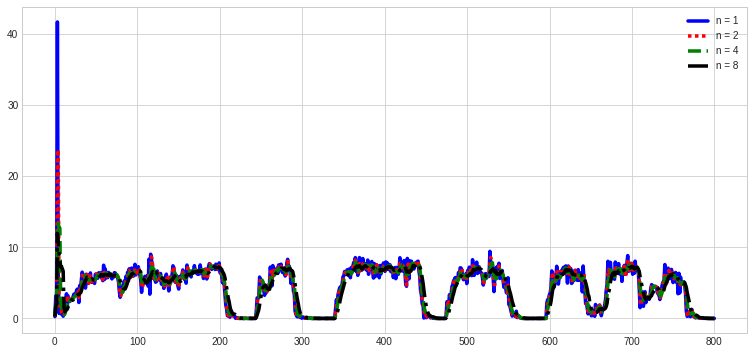

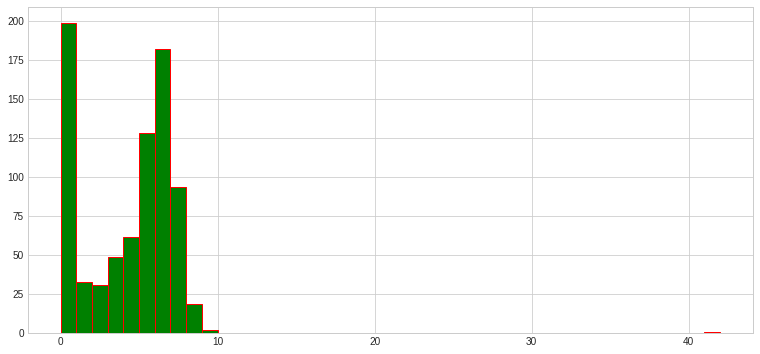

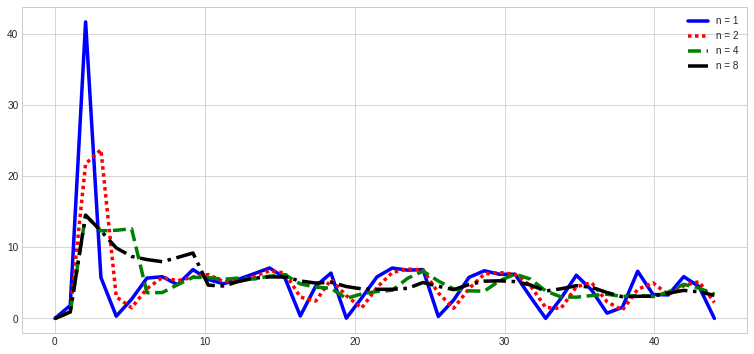

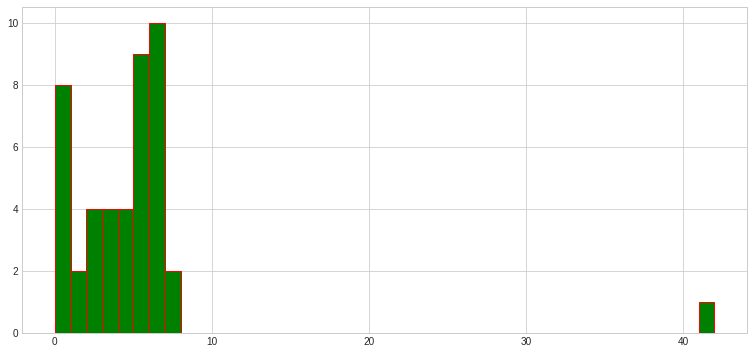

In [41]:
num_route = 0
nb_graph=0

df_temp = df[df["route_num"]==num_route]
tab_speed = data.compute_speed(df_temp)
#df_temp.insert(loc=2, column='speed', value=tab_speed)
df_temp = df_temp[df_temp["speed"]>0]
fig = plt.figure(figsize=graph_size)
ax = plt.axes()
x = np.linspace(0, len(df_temp), len(df_temp))
tab_avg_speed = data.compute_average_speed(df_temp, 1)
plt.plot(x, tab_avg_speed, color='blue', linewidth=3.5, label='n = 1')
tab_avg_speed = data.compute_average_speed(df_temp, 2)
plt.plot(x, tab_avg_speed, color='red', linestyle=(0,(1,1)), linewidth=3.5, label='n = 2')
tab_avg_speed = data.compute_average_speed(df_temp, 4)
plt.plot(x, tab_avg_speed, color='green', linestyle='dashed', linewidth=3.5, label='n = 4')
tab_avg_speed = data.compute_average_speed(df_temp, 8)
plt.plot(x, tab_avg_speed, color='black', linestyle='dashdot', linewidth=3.5, label='n = 8')
plt.legend(loc='upper right')
#plt.savefig('images/graph_'+str(nb_graph)+'.png')

tab_speed = df_temp["speed"].values
fig = plt.figure(figsize=graph_size)
values, _, _ = plt.hist(tab_speed, range(0, int(max(tab_speed)+2)), color='green', edgecolor = 'red')
plt.plot()

df_temp_simplified = df_simplified[df_simplified["route_num"]==num_route]
fig = plt.figure(figsize=graph_size)
ax = plt.axes()
x = np.linspace(0, len(df_temp_simplified), len(df_temp_simplified))
tab_avg_speed = data.compute_average_speed(df_temp_simplified, 1)
plt.plot(x, tab_avg_speed, color='blue', linewidth=3.5, label='n = 1')
tab_avg_speed = data.compute_average_speed(df_temp_simplified, 2)
plt.plot(x, tab_avg_speed, color='red', linestyle=(0,(1,1)), linewidth=3.5, label='n = 2')
tab_avg_speed = data.compute_average_speed(df_temp_simplified, 4)
plt.plot(x, tab_avg_speed, color='green', linestyle='dashed', linewidth=3.5, label='n = 4')
tab_avg_speed = data.compute_average_speed(df_temp_simplified, 8)
plt.plot(x, tab_avg_speed, color='black', linestyle='dashdot', linewidth=3.5, label='n = 8')
plt.legend(loc='upper right')
#plt.savefig('images/graph_'+str(nb_graph)+'_simplified.png')

tab_speed = df_temp_simplified["speed"].values
fig = plt.figure(figsize=graph_size)
values, _, _ = plt.hist(tab_speed, range(0, int(max(tab_speed)+2)), color='green', edgecolor = 'red')
plt.plot()

# Spatial clusters

In [8]:
with open("files/"+project_folder+"_wtime/clustering/dbscan_observations.dict",'rb') as infile:
    spatial_clusters = pickle.load(infile)

In [9]:
num_cluster = 0
print(len(spatial_clusters[num_cluster]))
#dp.display_routes(df_simplified, dict_cluster[nb_cluster])
dp.display_cluster_heatmap(df_simplified, spatial_clusters[num_cluster])

352


/home/lucas/Projects/cycling-predictive-model/python/display.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["num_route"] = i


# Temporal clusters

In [57]:
new_temporal_clusters = False
if(new_temporal_clusters):
    #tab_time_specification = []
    for i in range(df_simplified.iloc[-1]["route_num"]):
        print(i)
        df_temp = df[df["route_num"]==i]
        tab_speed = df_temp["speed"].values
        tab_time_specification.append(np.histogram(tab_speed, bins=range(0, int(max(tab_speed)+2))))
            
        '''df_temp_s = df_simplified[df_simplified["route_num"]==i]
        tab_speed = df_temp["speed"].values
        tab_time_specification[-1].append(sum(i < 1 for i in tab_speed))
        for i in range(1, 9):
            tab_avg_speed = data.compute_average_speed(df_temp, i)
            tab_time_specification[-1].append(statistics.mean(tab_avg_speed))
            tab_time_specification[-1].append(statistics.stdev(tab_avg_speed))'''
        with open("files/"+project_folder+"_wtime/data_processed/time_specification.tab",'wb') as outfile:
            pickle.dump(tab_time_specification, outfile)
else:
    with open("files/"+project_folder+"_wtime/data_processed/time_specification.tab",'rb') as infile:
        tab_time_specification = pickle.load(infile)
print(len(tab_time_specification))

3601


In [92]:
kmeans = KMeans(n_clusters=10, random_state=0)
X = normalize(tab_time_specification)
temporal_clusters = cl.cluster(X, kmeans)

gm = GaussianMixture(15)
gm.fit(X)
temporal_clusters = gm.predict(X)
dict_temporal_clusters = cl.tab_clusters_to_dict(temporal_clusters)

cl.cluster_properties(dict_temporal_clusters, tab_time_specification, temporal_clusters)
print(len(dict_temporal_clusters)-1, "clusters")
print("noise:", temporal_clusters.tolist().count(-1))
print("size of clusters:", [len(dict_temporal_clusters[key]) for key in dict_temporal_clusters])


silhouette score : -0.2654864965774257

mean size : 257.2142857142857

13 big clusters: [14, 8, 11, 9, 5, 2, 1, 12, 4, 3, 0, 13, 6]
0 mini clusters : []
14 clusters
noise: 0
size of clusters: [577, 311, 765, 430, 89, 104, 74, 272, 193, 120, 334, 79, 206, 22, 25]


[]

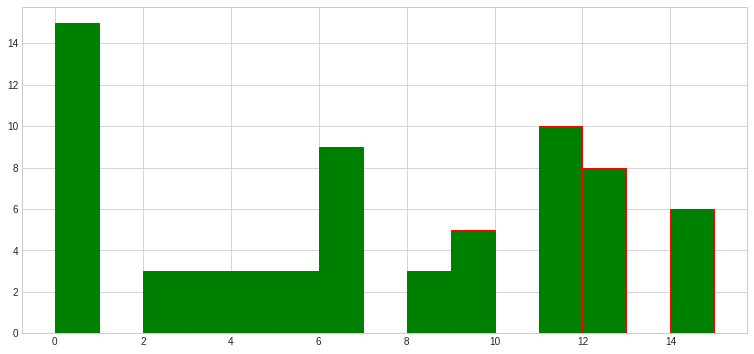

In [95]:
num_cluster = 5
tab_hist = []

for num_route in spatial_clusters[num_cluster]:
    tab_hist.append(temporal_clusters[num_route])
fig = plt.figure(figsize=graph_size)
values, _, _ = plt.hist(tab_hist, range(0, max(temporal_clusters)+2), color='green', edgecolor = 'red')
plt.plot()
